In [3]:
import numpy as np

from utils import *
from core import *
import imageio.v3 as iio
from PIL import Image

im = iio.imread('../assets/800px-SheppLogan.png')

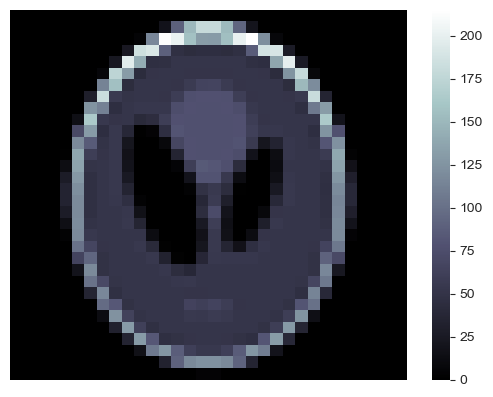

In [4]:
# loading image
new_res = 32

img = Image.fromarray(im).resize((new_res, new_res))
img = np.array(img.convert('L'))
plot_image(img, cmap='bone')

In [5]:
A = CreateInterceptMatrix(
  no_of_detectors=new_res,
  source_to_object=20,
  source_to_detector=40,
  size_of_object=15,
  no_of_rotations=new_res,
  angle_bw_detectors=0.05,
  resolution=new_res
).create_intercept_matrix_from_lines()

In [6]:
import torch

torch.set_default_device('cuda')

A = torch.from_numpy(A)

In [30]:
def power_iteration(A, num_iterations):
    """
    power iterations to find out 1 eigenvector of given matrix
    """
    b = torch.rand(A.shape[1], dtype=torch.double)

    for _ in range(num_iterations):
        Ab = torch.mv(A, b)

        norm = torch.linalg.vector_norm(Ab)
        b = torch.div(Ab, norm)

    return b

def svd(A, num_iterations=1000, tol=1e-8):
    """
    return SVD of matrix A, S will be of (r,r) dimensions where r is rank of matrix A
    equivalent to numpy's np.linalg.svd(A, full_natrices=False) with tolerance for singular values
    """
    ATA = torch.mm(A.T, A)

    V = []
    S = []
    i = 0
    # finding right singular vectors
    for _ in tqdm(range(min(ATA.shape)), desc='Performing decomposition'):
        eigenvector = power_iteration(ATA, num_iterations)
        eigenvalue = torch.linalg.multi_dot([eigenvector, ATA, eigenvector])
        if i > 4:
            break
        if eigenvalue < tol:
            i += 1
            continue


        eigenvector /= torch.norm(eigenvector)

        V.append(eigenvector)
        S.append(eigenvalue)

        # reduce lambda * vT v from the eigendecomposition of AtA
        ATA = ATA - eigenvalue * torch.outer(eigenvector, eigenvector)

    if not S:
        raise ValueError('Matrix has rank 0')

    S = torch.sqrt(torch.tensor(S, dtype=torch.double))

    # find the left singular vectors
    V = torch.column_stack(V)
    U = torch.linalg.multi_dot([A, V, 1/S])
    return U, S, V.T

In [31]:
U, S, Vt = svd(A, num_iterations=200)

Performing decomposition:  58%|█████▊    | 597/1024 [00:26<00:18, 22.72it/s]


In [32]:
S_lib = torch.linalg.svdvals(A)

In [33]:
r = torch.linalg.matrix_rank(A, tol=1e-8).item()
r

600

In [34]:
r_ = S.shape[0]
r_

592

In [35]:
# maximum error
error = torch.sub(S.cpu(), S_lib[:r_])
error.max(), error.mean()

(tensor(0.0216, dtype=torch.float64), tensor(6.4240e-06, dtype=torch.float64))

In [36]:
S_lib[r_]

tensor(0.0188, dtype=torch.float64)

C:\Users\msing\AppData\Local\Temp\ipykernel_15700\1925273464.py:2: RuntimeWarning: invalid value encountered in log
  sns.kdeplot(np.log(np.array(error)))


<Axes: ylabel='Density'>

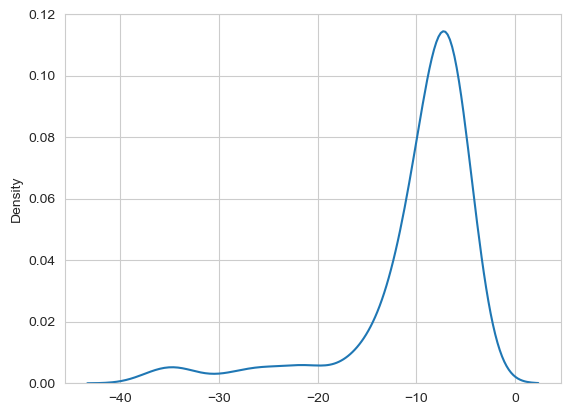

In [13]:
import seaborn as sns
sns.kdeplot(np.log(np.array(error)))